# Deep Reinforcement Learning

![mario](./images/mario.jpg)

Reinforcement learning is one of the hottest (if not the hottest) area of deep learning. It is possibly the closest that we have come to achieving general AI at this point in time. The reason it is touted as getting close to general AI is that we can use the same framework repeatedly in different environments to maximise future rewards. Apart from the ATARI games in which [Deep Reinforcement Learning got famous](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) for and beating the current world GO chamption, it is now being used in finance and [teaching robots to walk](https://www.youtube.com/watch?v=JFJkpVWTQVM).

The general concept of RL is to simulate game a large number of times and to learn which actions constitutes a good move. One of the biggest challenges that RL faces is to infer what constitutes a good move. A good move at the current state might be a bad move for future states. This is definitely the case in playing chess for example where you constantly sacrifice pieces for larger future rewards.

## Belman Equation

The goal of reinforcement learning is to maximise its return. In this tutorial we get 'envirnonments' from OpenAI which provides us a game, the physics/ rules by which the game is controlled by and outputs the **rewards** achieved for a given **action**, at the current **state** of the game.

The bellman equation plays a crucial role in reinforcement learning.
\begin{align}
Q(S_t)(a_t) = r_t + \gamma\max_{a_{t+1}}Q(S_{t+1})(a_{t+1})
\end{align}
where $Q$ is a quality function, which depends on state $S_t$ and outputs the maximum possible future reward for action $a_t$. $\gamma$ is a discount factor. Most texts would prefer to depict the Quality function as $Q(S_t, a_t)$, however I wish to stress that $Q(S_t)$ outputs the maximum discounted future reward for all actions. $a_t$ is in this tutorial, a one-hot encoded variable which helps to choose a reward for all possible actions. **Notice how could recursively expand this function.**

## Pseudocode for DQN
Reference: https://github.com/yenchenlin/DeepLearningFlappyBird
```
Initialize replay memory D to size N
Initialize action-value function Q with random weights
for episode = 1, M do
    Initialize state s_1
    for t = 1, T do
        With probability ϵ select random action a_t
        otherwise select a_t=max_a  Q(s_t,a; θ_i)
        Execute action a_t in emulator and observe r_t and s_(t+1)
        Store transition (s_t,a_t,r_t,s_(t+1)) in D
        Sample a minibatch of transitions (s_j,a_j,r_j,s_(j+1)) from D
        Set y_j:=
            r_j for terminal s_(j+1)
            r_j+γ*max_(a^' )  Q(s_(j+1),a'; θ_i) for non-terminal s_(j+1)
        Perform a gradient step on (y_j-Q(s_j,a_j; θ_i))^2 with respect to θ
    end for
end for
```


## Reference:

- https://keon.io/deep-q-learning/
- http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html
- https://github.com/yenchenlin/DeepLearningFlappyBird
- [Playing Atari with Deep Reinforcement Learning](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)
- [OpenAI environments](https://gym.openai.com/envs/)
- https://www.youtube.com/watch?v=JFJkpVWTQVM



In [ ]:
!pip install gym
!conda install -y JSAnimation

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re

from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dot
from keras.models import load_model, model_from_json
from keras.optimizers import Adam

import gym

from collections import deque

import time

%matplotlib inline

# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

Using TensorFlow backend.


In [2]:
def create_model(n_states, n_actions):
    
    state = Input(shape=(n_states,))
    # TODO: Fill in the following with 2 Dense Layers
    # see https://keras.io/getting-started/functional-api-guide/
    x1 = 
    x2 = 
    out = Dense(n_actions)(x2)
    actions = Input(shape=(n_actions,))
    out2 = Dot(axes=-1)([out, actions])

    model = Model(inputs=[state, actions], outputs=out2)
    model.compile(loss='mse', optimizer='rmsprop')
    
    model2 = Model(inputs=state, outputs=out)

    return model, model2

In [3]:
def train_data(minibatch, model):
    s_j_batch = np.array([d[0] for d in minibatch])
    a_batch = np.array([d[1] for d in minibatch])
    r_batch = np.array([d[2] for d in minibatch])
    s_j1_batch = np.array([d[3] for d in minibatch])
    terminal_batch = np.array([d[4] for d in minibatch])

    ##############################################################
    # The following 3 lines are the most important part of Deep RL
    ##############################################################
    readout_j1_batch = model.predict(s_j1_batch, batch_size=BATCH)
    y_batch = r_batch + GAMMA * np.max(readout_j1_batch, axis=1)
    y_batch[terminal_batch] = r_batch[terminal_batch]
    
    return s_j_batch, a_batch, y_batch

## OpenAI functions

- env = gym.make(environment_name) <- sets up the environment
- env.reset() <- resets the environment to starting point
- env.step(action) <- takes action and goes to state $S_{t+1}$ 
- env.render() <- render the output

In [4]:
env = gym.make('CartPole-v0')
STATES, ACTIONS = env.observation_space.shape[0], env.action_space.n
model, out = create_model(STATES, ACTIONS)
INITIAL_EPSILON = 1e-1
FINAL_EPSILON = 1e-4
DECAY = 0.9
GAMMA = 0.9 # decay rate of past observations
OBSERVE = 5000. # timesteps to observe before training
REPLAY_MEMORY = 5000 # number of previous transitions to remember
TIME_LIMIT = 100000
BATCH = 128
# open up a game state to communicate with emulator
state = env.reset()

# store the previous observations in replay memory
D = deque(maxlen=REPLAY_MEMORY)
loss = []

a_t = np.zeros(ACTIONS)
a_t[np.random.choice(ACTIONS)] = 1
s_t, r_0, terminal, _ = env.step(np.argmax(a_t))

# start training
epsilon = INITIAL_EPSILON

up_time = [0]
start = time.time()
for t in range(TIME_LIMIT):
    # choose an action
    readout_t = out.predict(s_t[None, :])
    a_t = np.zeros([ACTIONS])
    if np.random.random() <= epsilon:
        a_t[np.random.choice(ACTIONS)] = 1
    else:
        a_t[np.argmax(readout_t)] = 1

    # scale down epsilon
    if epsilon > FINAL_EPSILON and t > OBSERVE:
        # TODO: decay the epsilon value
        epsilon = 

    # run the selected action and observe next state and reward
    # store the transition in D
    # TODO: Take a step for the current environment (see lines above this cell)
    s_t1, r_t, terminal, _ = 
    D.append((s_t, a_t, r_t, s_t1, terminal))
    
    if terminal:
        up_time.append(0)
        env.reset()
    else:
        up_time[-1] += r_t
    
    # only train if done observing
    if t > OBSERVE:
        # sample a minibatch to train on
        idx = np.random.choice(REPLAY_MEMORY, BATCH, replace=False)
        minibatch = [D[i] for i in idx]
        # get the batch variables
        s_t_batch, a_batch, y_batch = train_data(minibatch, out)
        # perform gradient step
        loss.append(model.train_on_batch([s_t_batch, a_batch], y_batch))

    # update the old state
    s_t = s_t1
        
    if t%(TIME_LIMIT/20)==0:
        print('Episode :', t, ', time taken: ', time.time() - start, 's, average up time: ',np.mean(up_time[-100:]))
        start = time.time()

[2017-10-18 18:24:26,754] Making new env: CartPole-v0


Episode : 0 , time taken:  0.04702281951904297 s, average up time:  1.0
Episode : 5000 , time taken:  1.6890149116516113 s, average up time:  8.63
Episode : 10000 , time taken:  11.951380014419556 s, average up time:  34.5
Episode : 15000 , time taken:  13.010540962219238 s, average up time:  56.53
Episode : 20000 , time taken:  11.975058794021606 s, average up time:  25.17
Episode : 25000 , time taken:  11.041939973831177 s, average up time:  44.6
Episode : 30000 , time taken:  11.701272964477539 s, average up time:  35.91
Episode : 35000 , time taken:  11.184820890426636 s, average up time:  30.13
Episode : 40000 , time taken:  11.266594886779785 s, average up time:  26.49
Episode : 45000 , time taken:  11.33695912361145 s, average up time:  28.31
Episode : 50000 , time taken:  11.028918027877808 s, average up time:  60.2
Episode : 55000 , time taken:  11.333147048950195 s, average up time:  85.6
Episode : 60000 , time taken:  11.429896831512451 s, average up time:  105.24
Episode : 

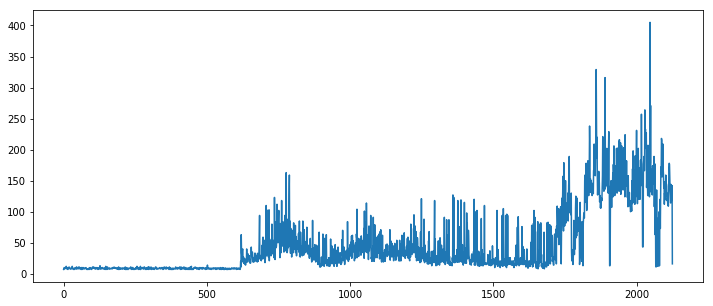

In [5]:
plt.figure(figsize=(12, 5))
plt.plot(up_time)
plt.show()

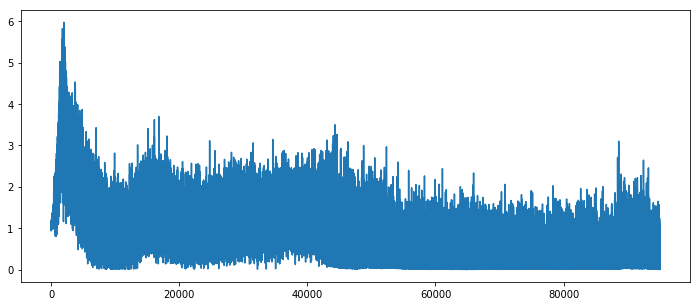

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(loss)
plt.show()

**Only run the following if you are running it locally and not in Docker**

In [7]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

[2017-10-18 18:28:03,126] Making new env: CartPole-v0



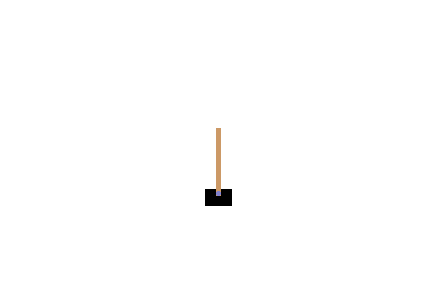
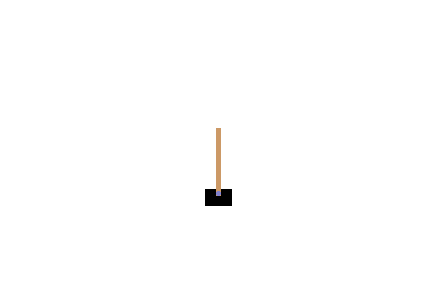
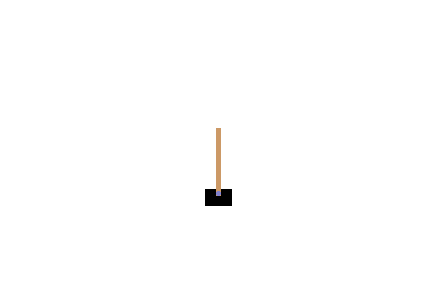
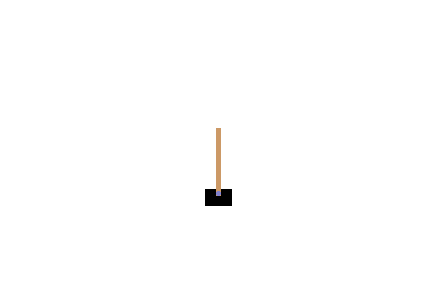
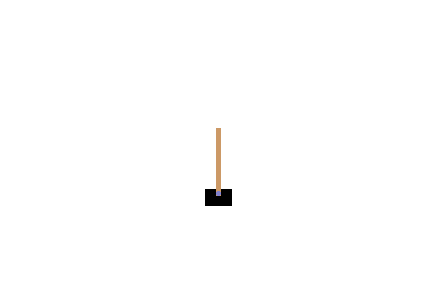
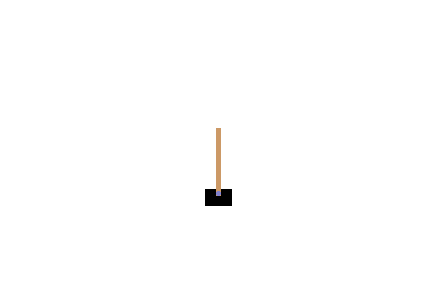
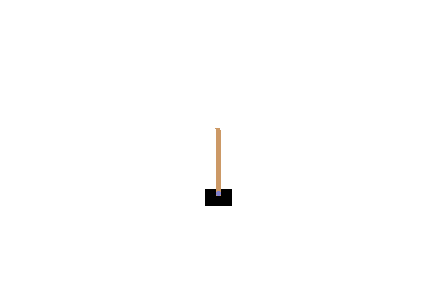
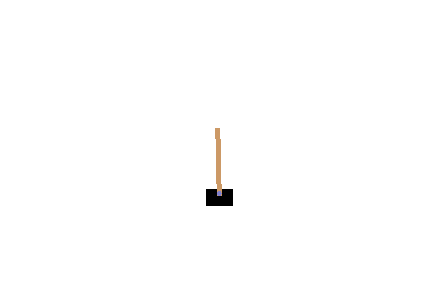
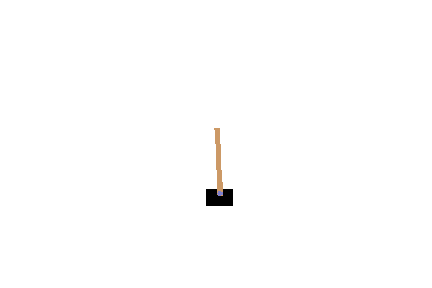
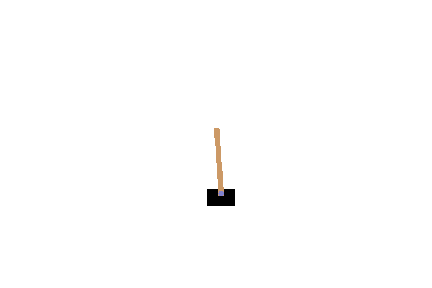
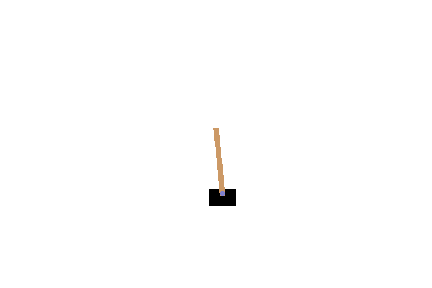
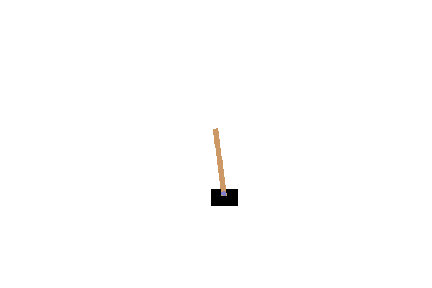
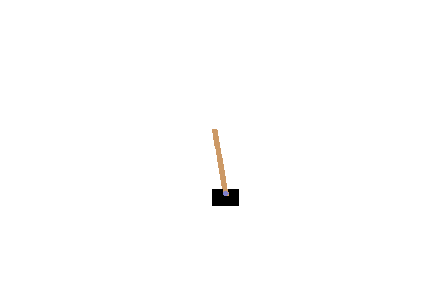

12


In [8]:
env = gym.make('CartPole-v0')

# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
for t in range(5000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)
print(t)


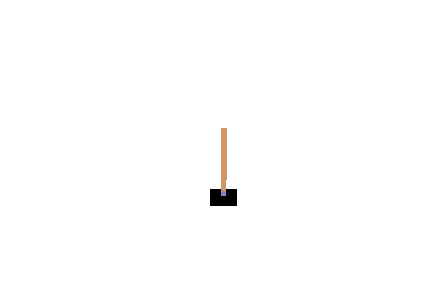
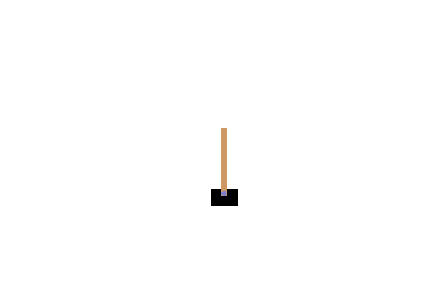
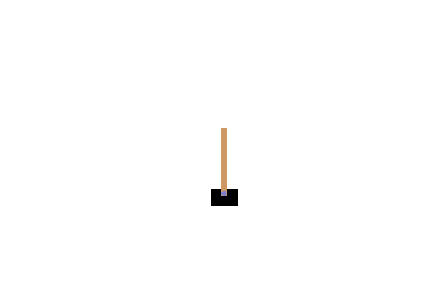
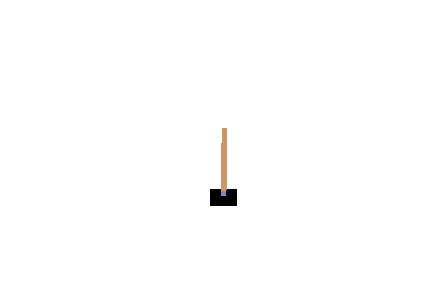
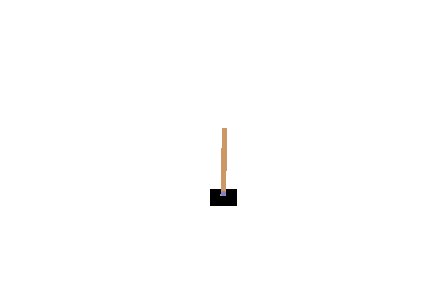
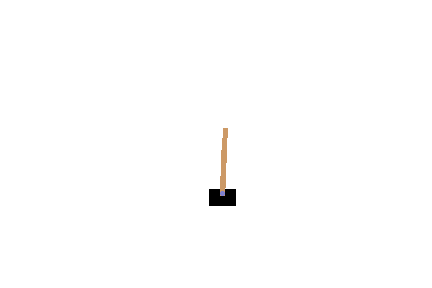
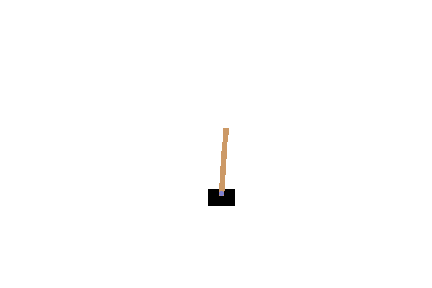
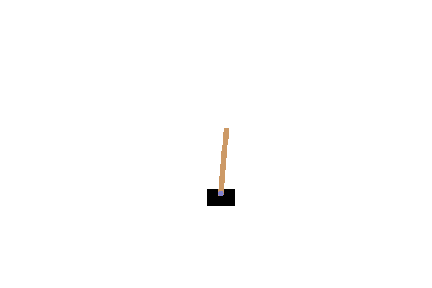
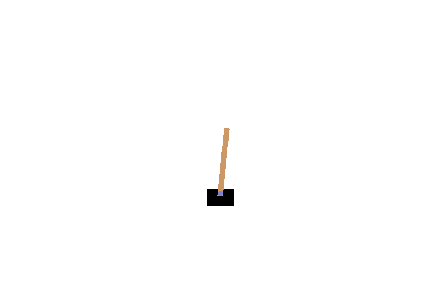
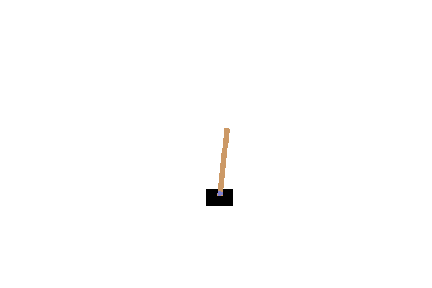
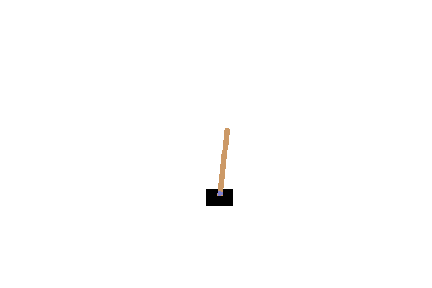
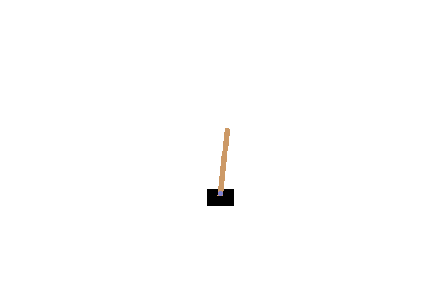
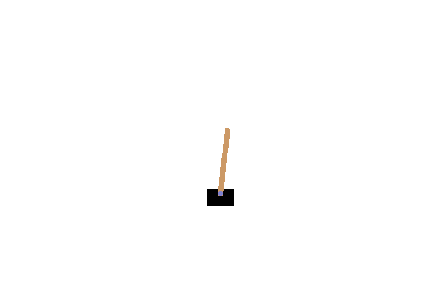
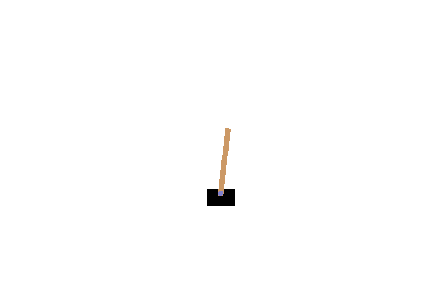
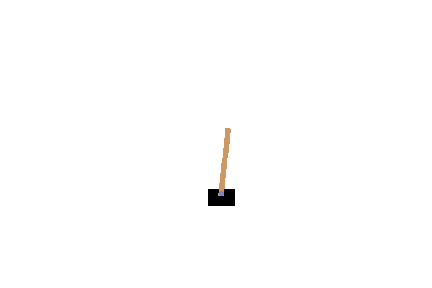
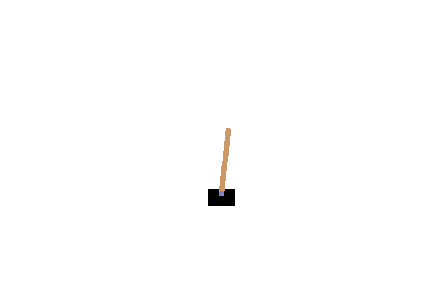
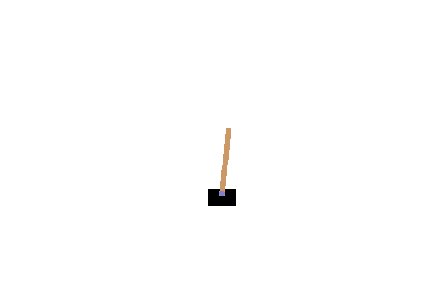
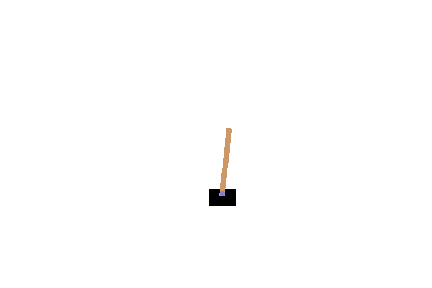
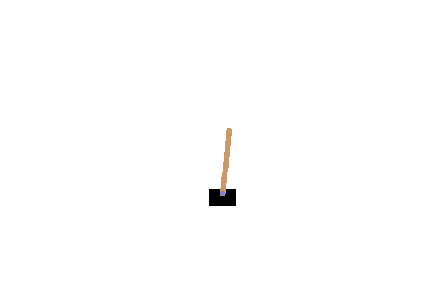
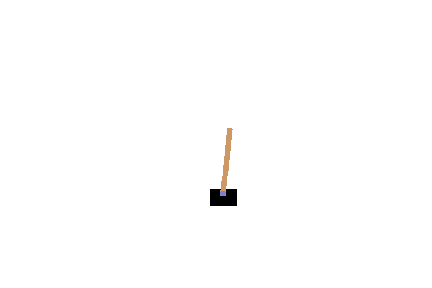
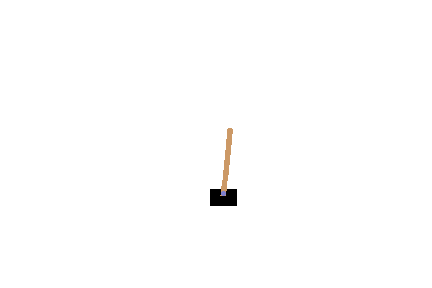
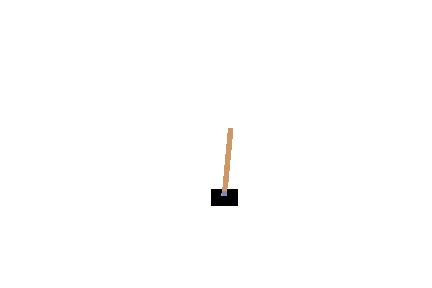
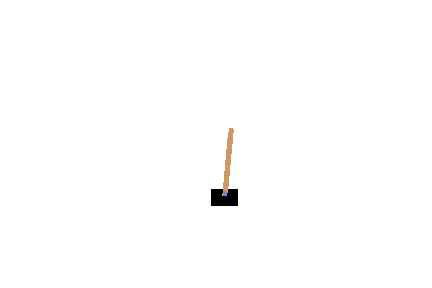
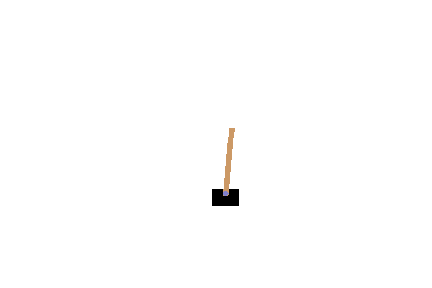
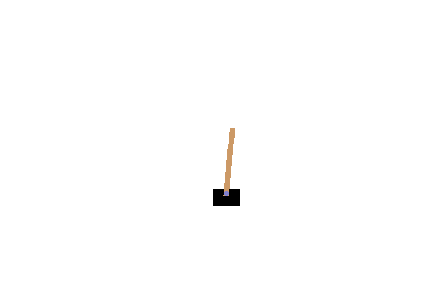
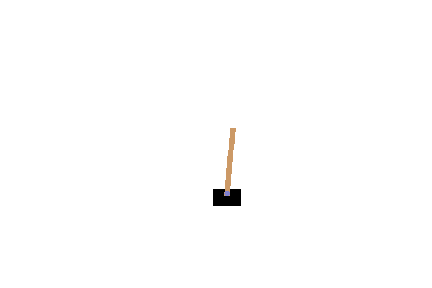
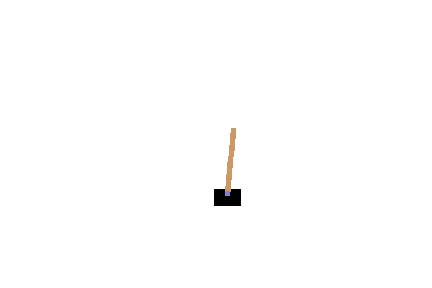
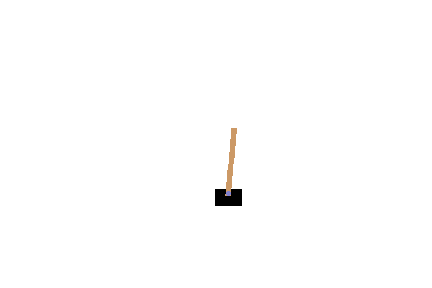
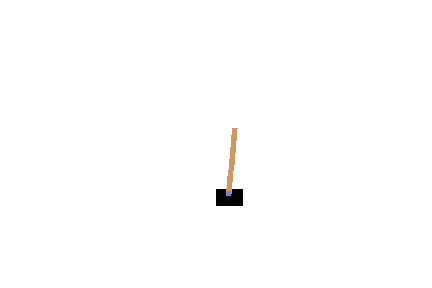
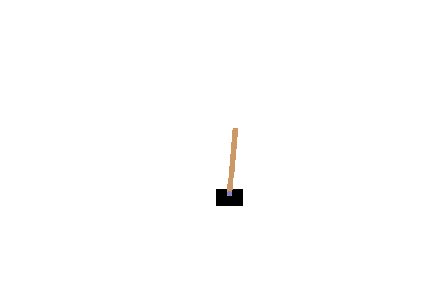
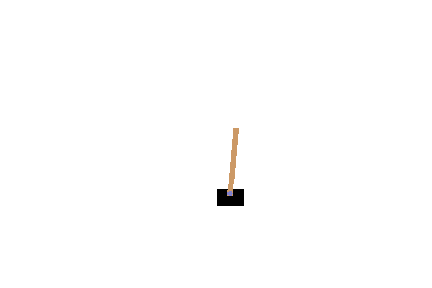
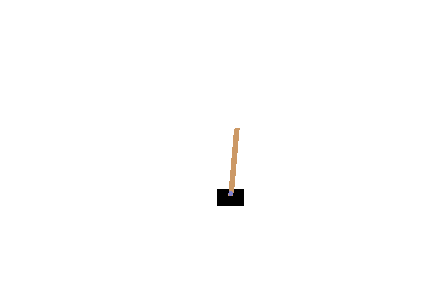
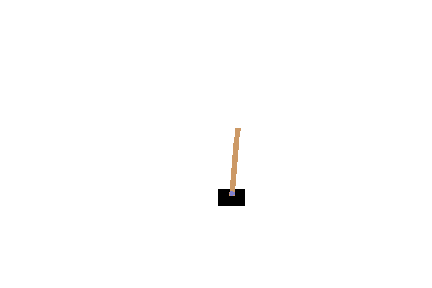
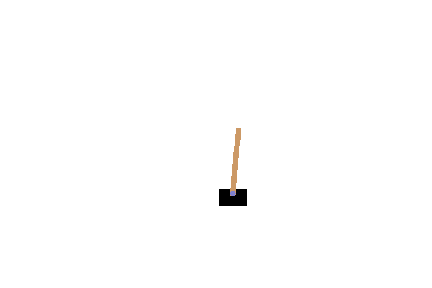
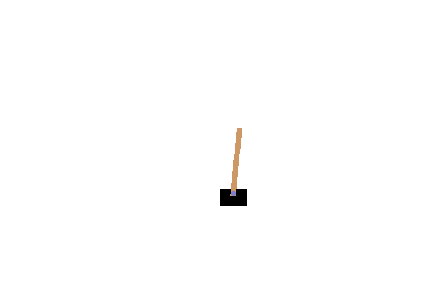
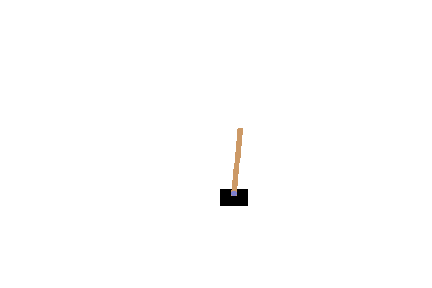
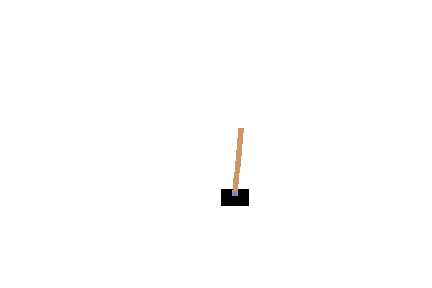
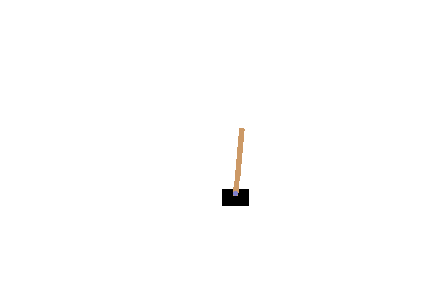
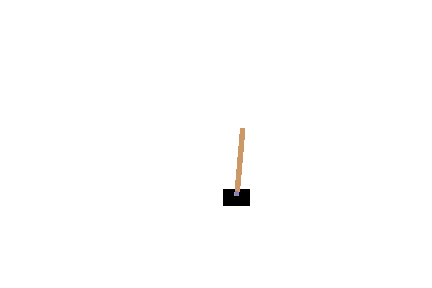
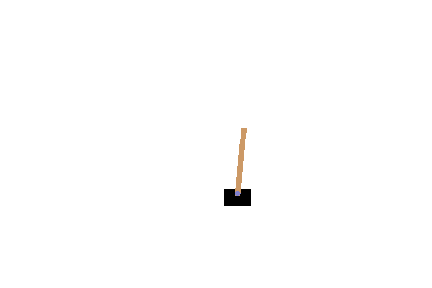
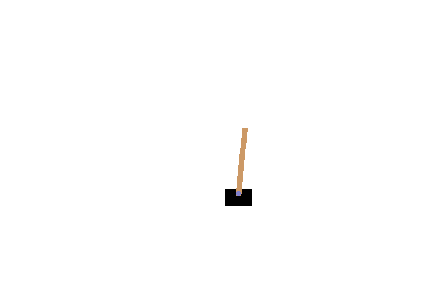
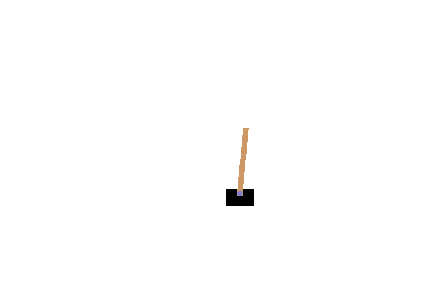
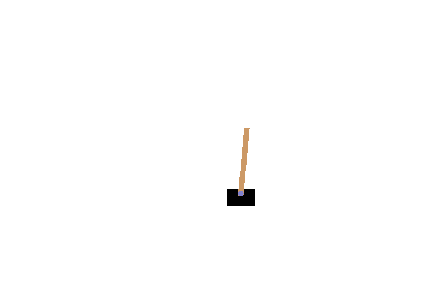
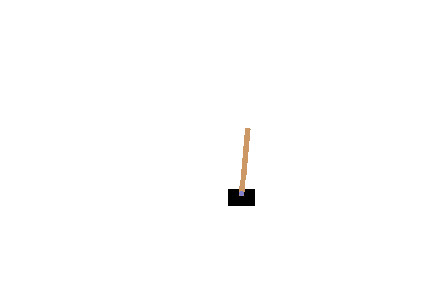
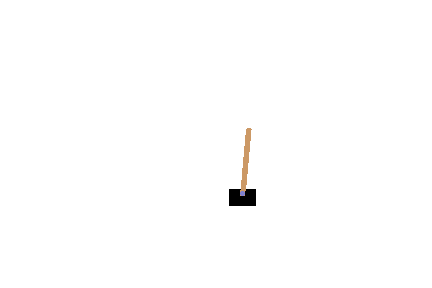
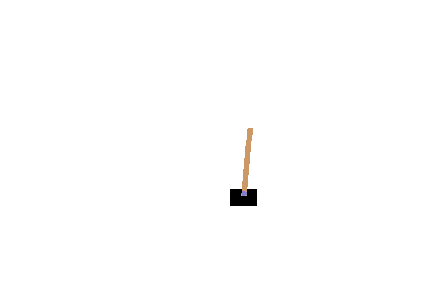
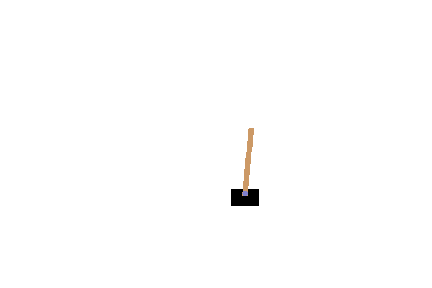
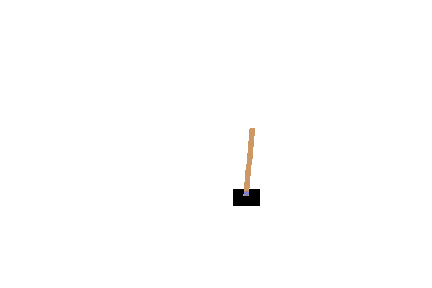
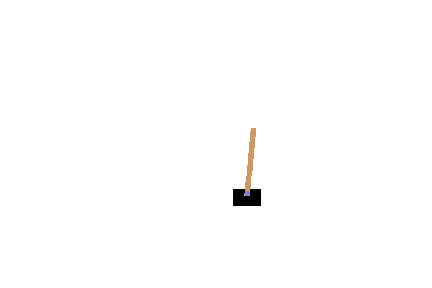
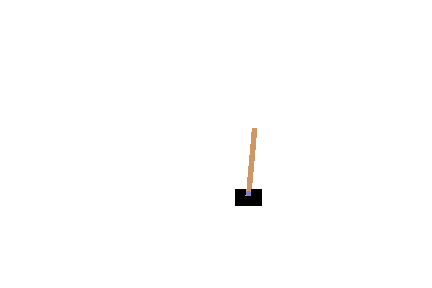
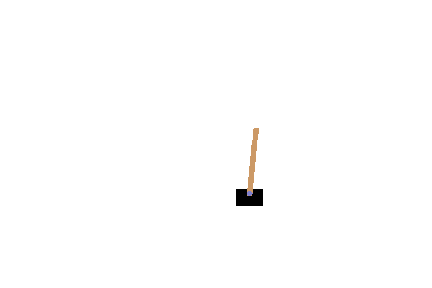
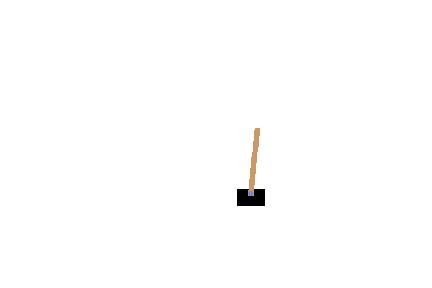
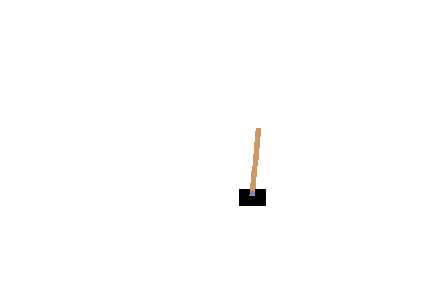
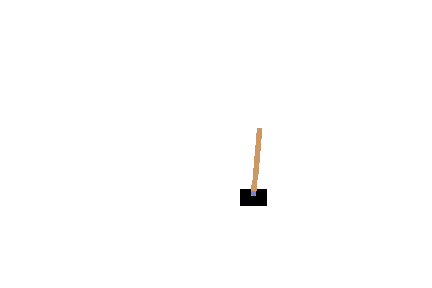
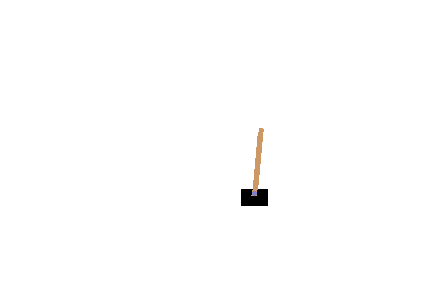
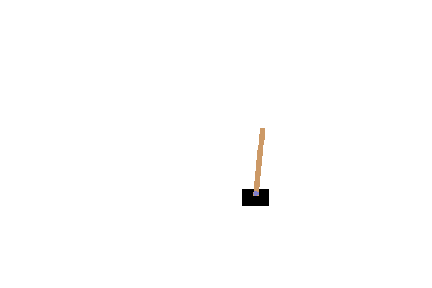
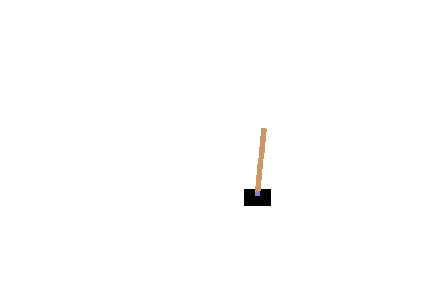
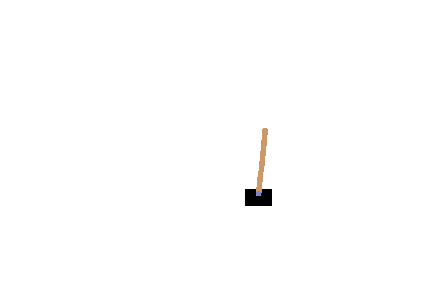
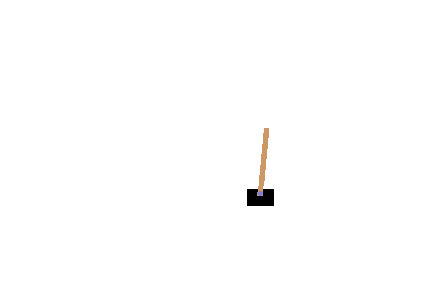
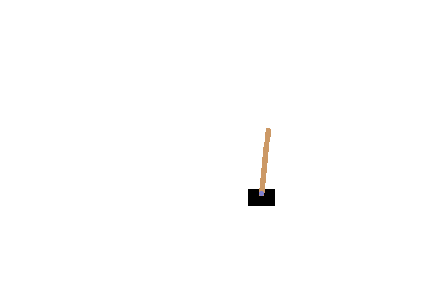
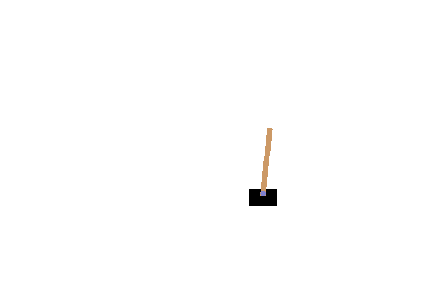
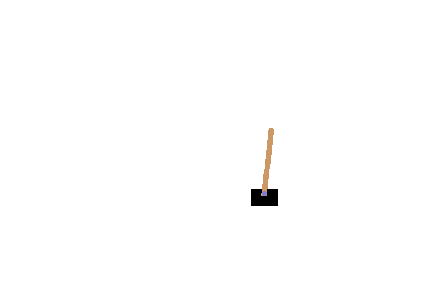
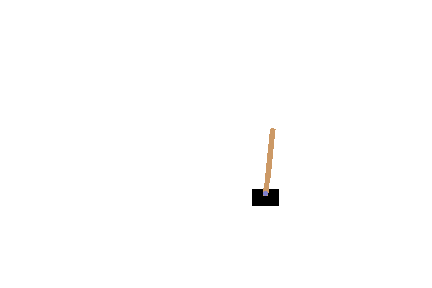
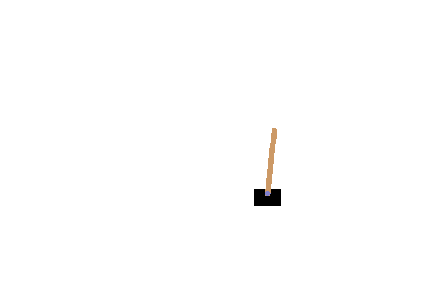
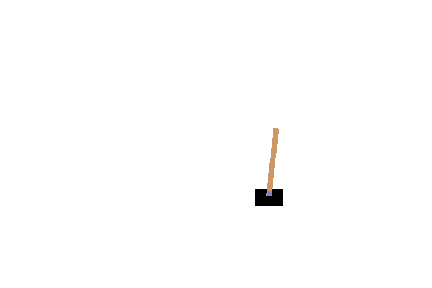
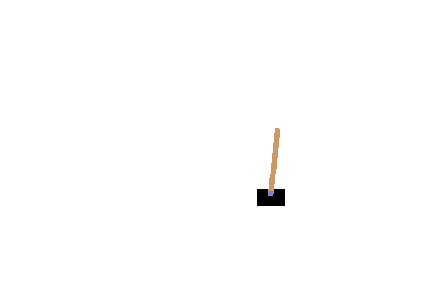
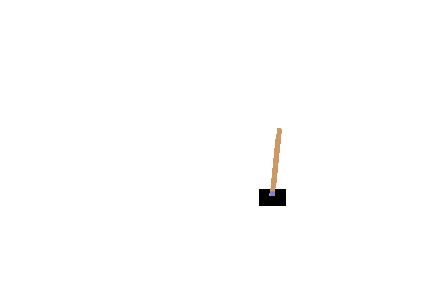
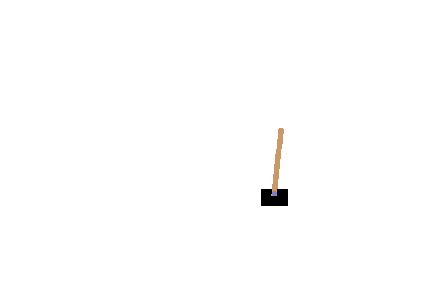
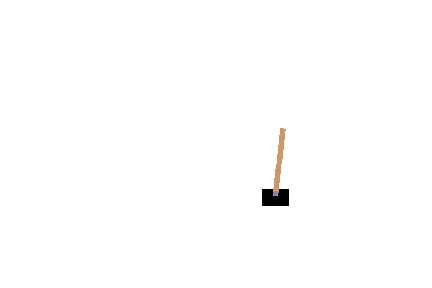
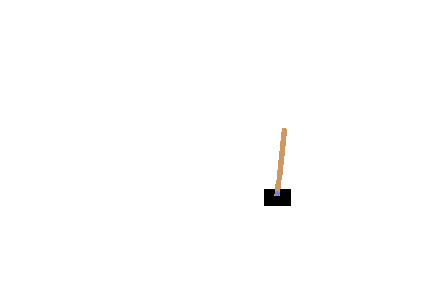
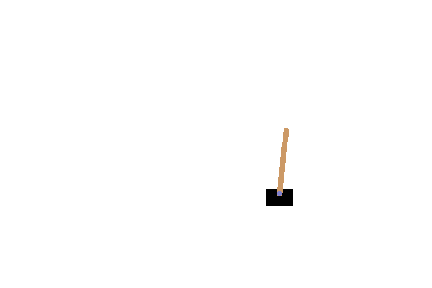
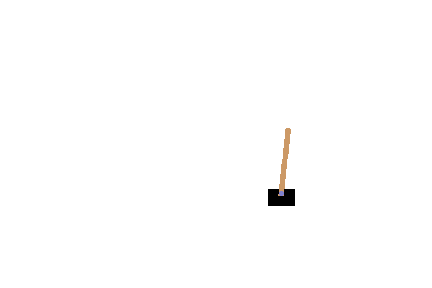
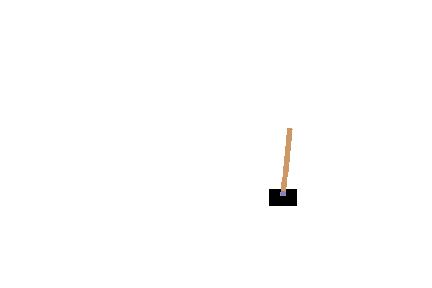
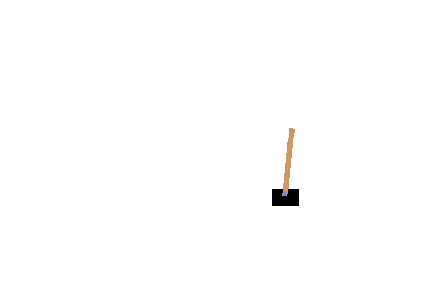
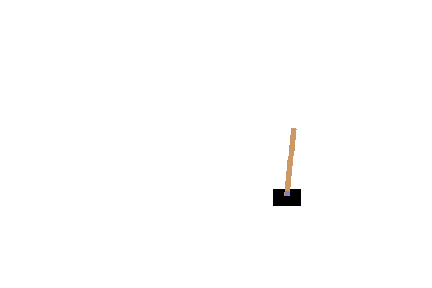
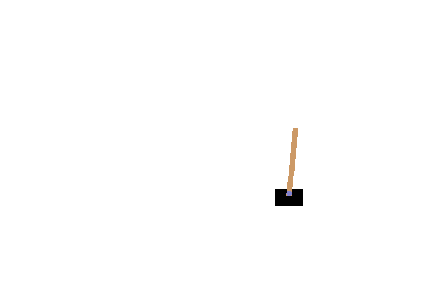
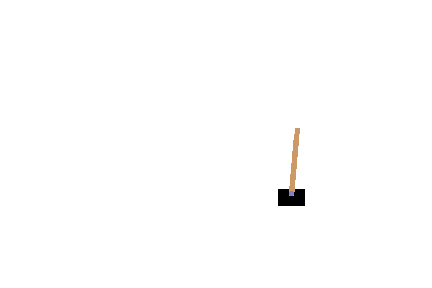
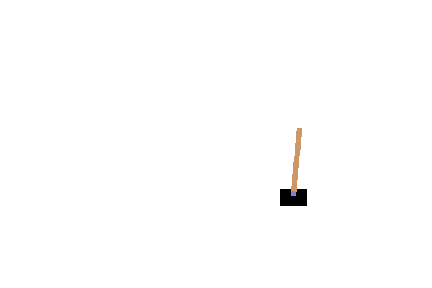
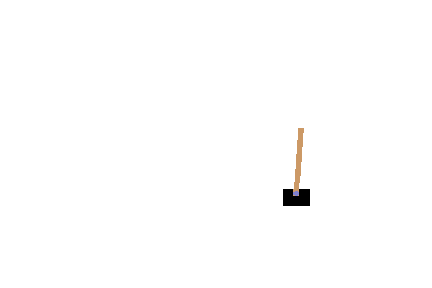
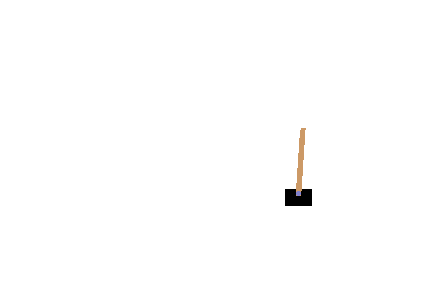
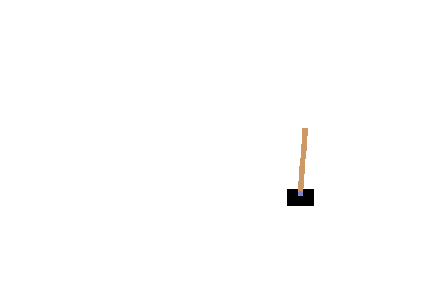
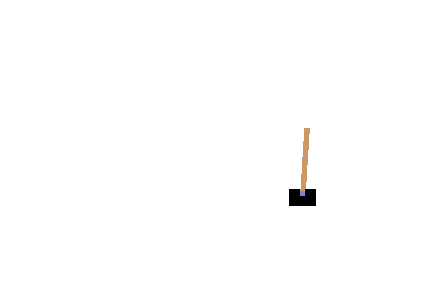
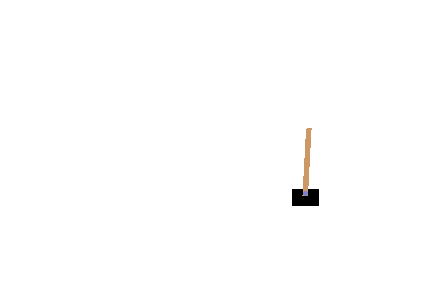
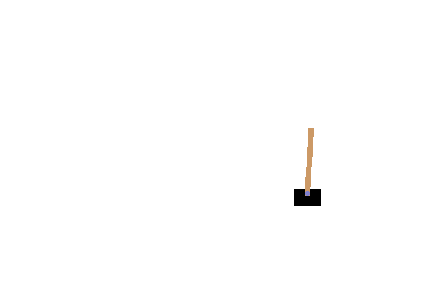
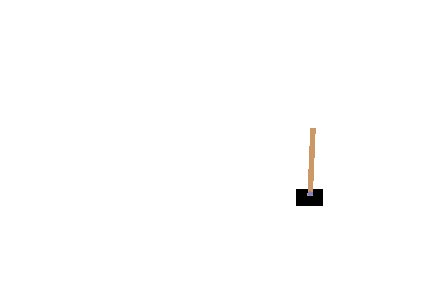
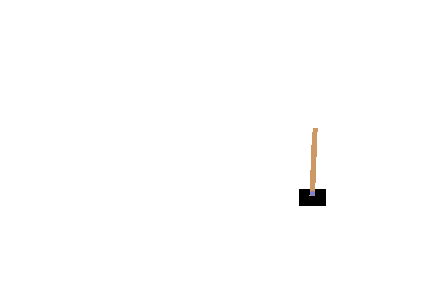
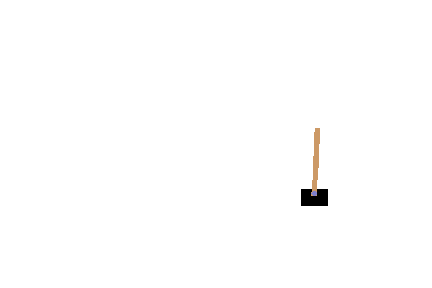
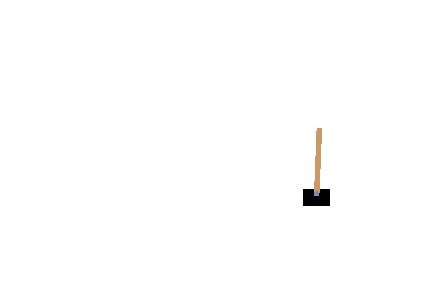
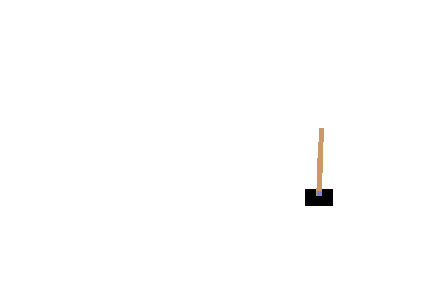
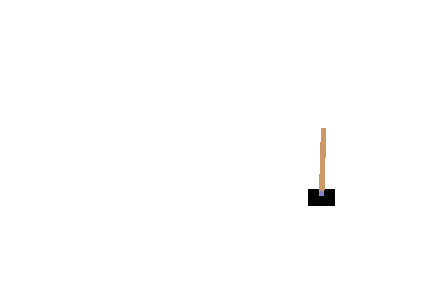
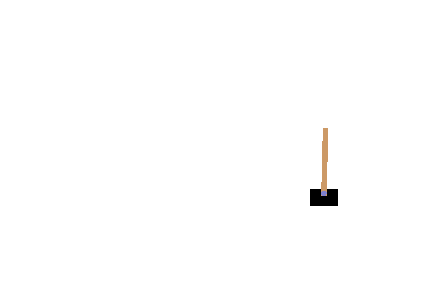
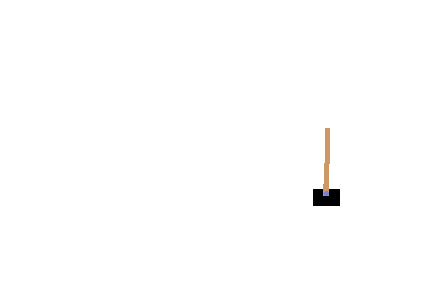
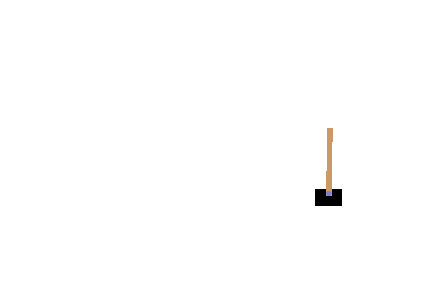
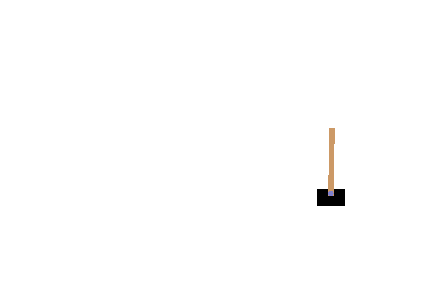
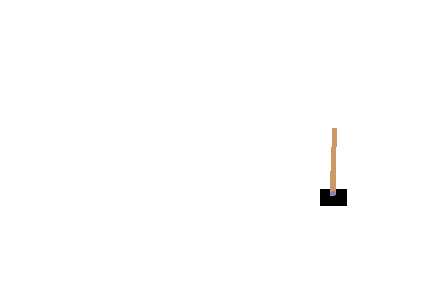
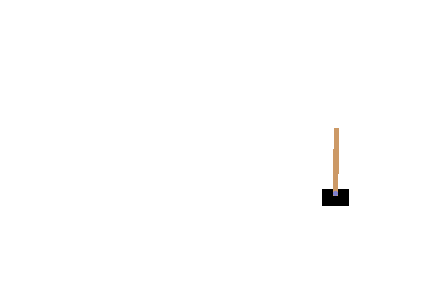
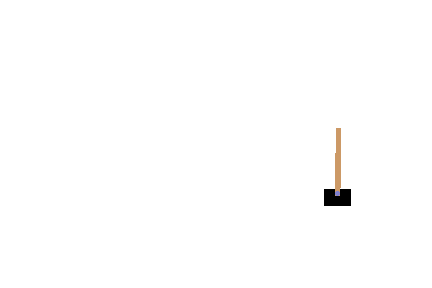
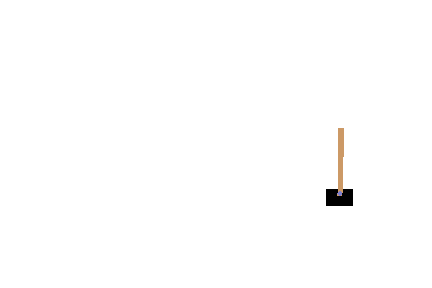
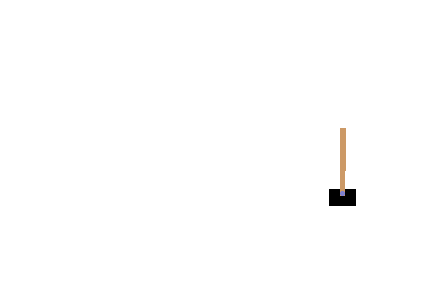
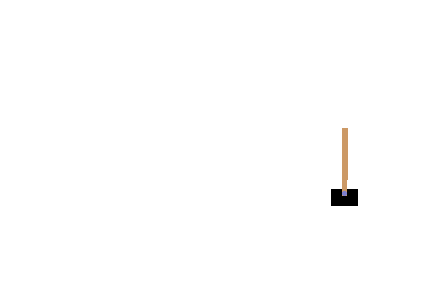
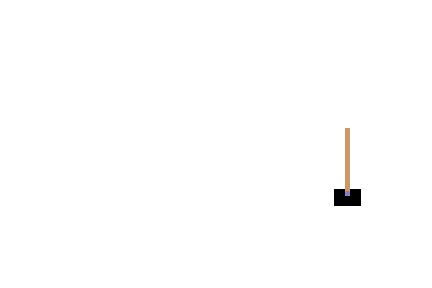
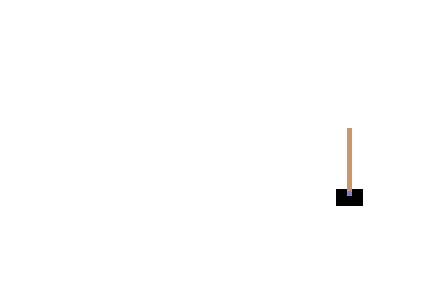
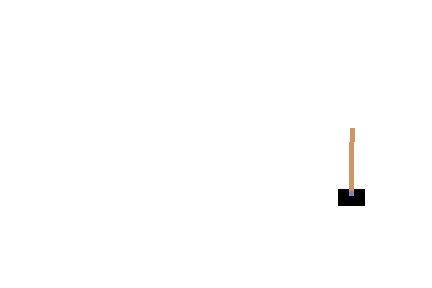
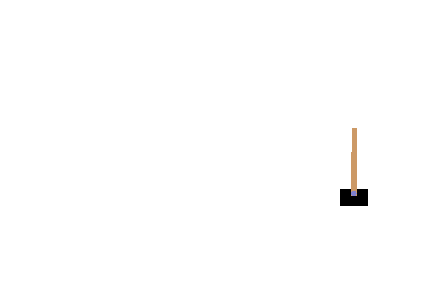
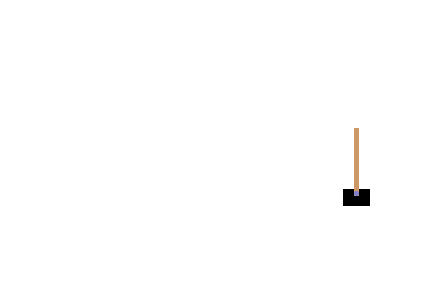
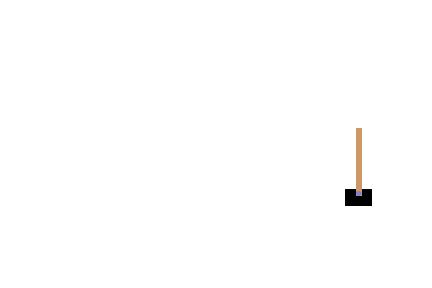
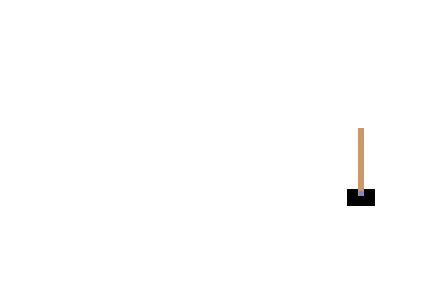
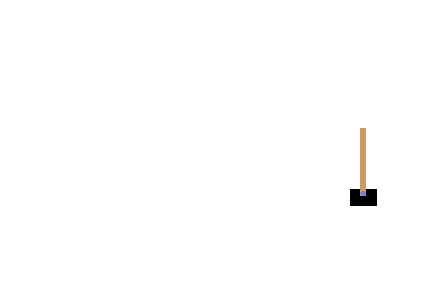
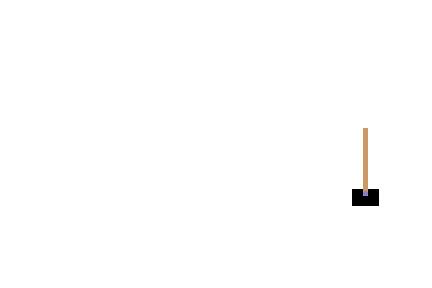
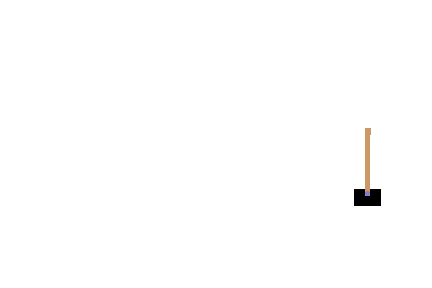
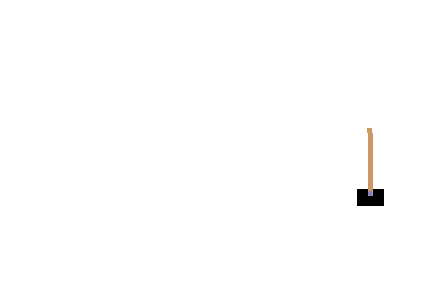
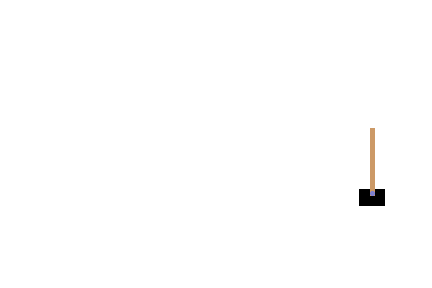
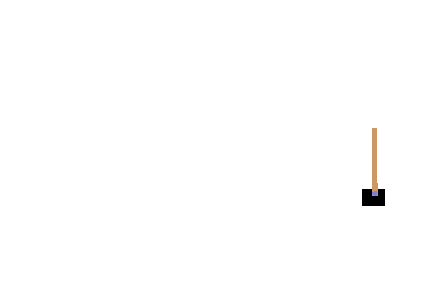
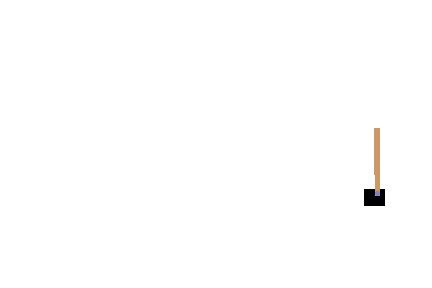
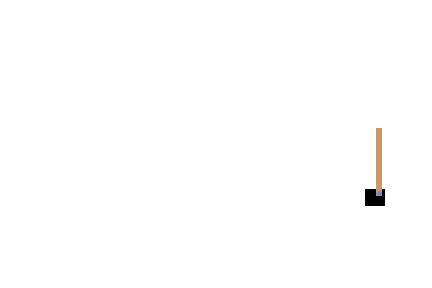
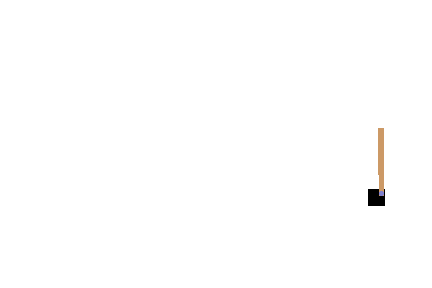
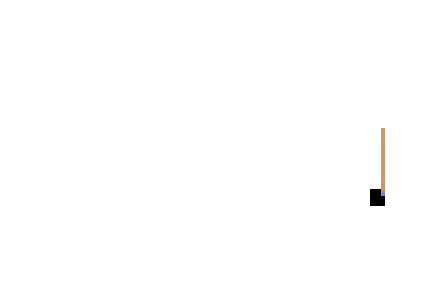
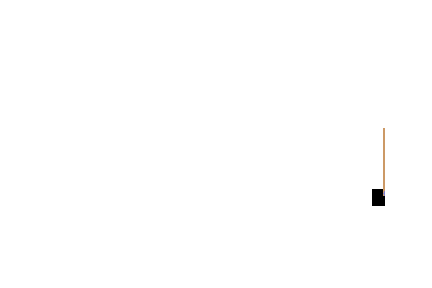

117


In [9]:
# Run a demo of the environment
observation = env.reset()
cum_reward = 0
frames = []
a_t = np.zeros([ACTIONS])
a_t[env.action_space.sample()] = 1
for t in range(5000):
    # Render into buffer.  
    s_t, reward, done, info = env.step(np.argmax(a_t))
    frames.append(env.render(mode = 'rgb_array'))
    readout_t = out.predict(s_t[None, :])
    a_t = np.zeros([ACTIONS])
    a_t[np.argmax(readout_t)] = 1
    
    if done:
        break
env.render(close=True)
display_frames_as_gif(frames)
print(t)